# 信用卡违约率检测
数据集：https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset

**任务**

对信用卡使用数据进行建模，预测用户是否下个月产生违约

**模型**
1. 算法模型：SVM、决策树、随机森林和KNN等
2. 网格搜索GridSearchCV工具，找到每个分类器的最优参数和最优分数，最终找到最适合数据集的分类器和此分类器的参数

**效果**

# 数据探索

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('./UCI_Credit_Card.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [4]:
# 变量类型
numeric_col = ['AGE','LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 
               'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
               'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
categorical_col = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
label_col = ['default.payment.next.month']
useless_col = ['ID']

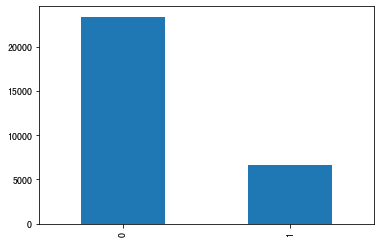

In [5]:
# 标签分布情况
data['default.payment.next.month'].value_counts().plot(kind='bar')
plt.show()

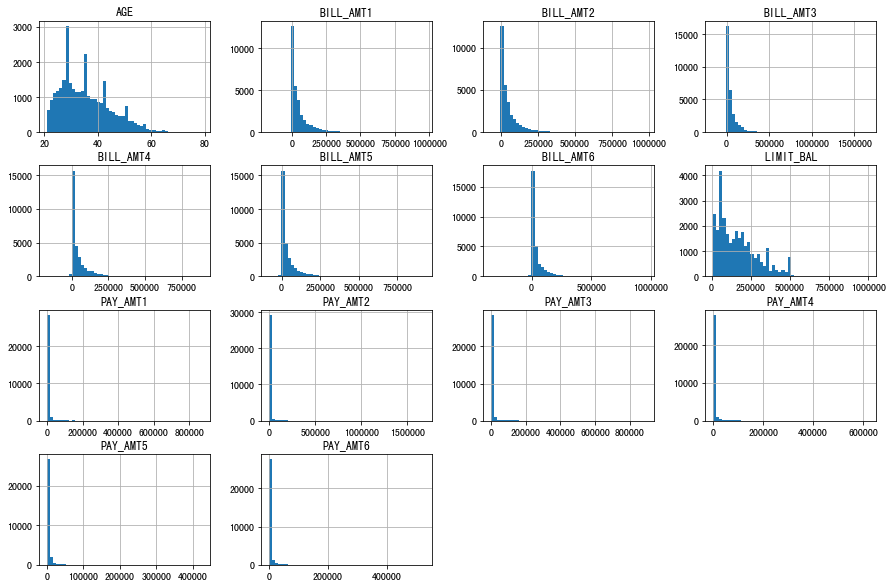

In [6]:
# 连续变量分布
data[numeric_col].hist(bins=50, figsize=(15,10))
plt.show()

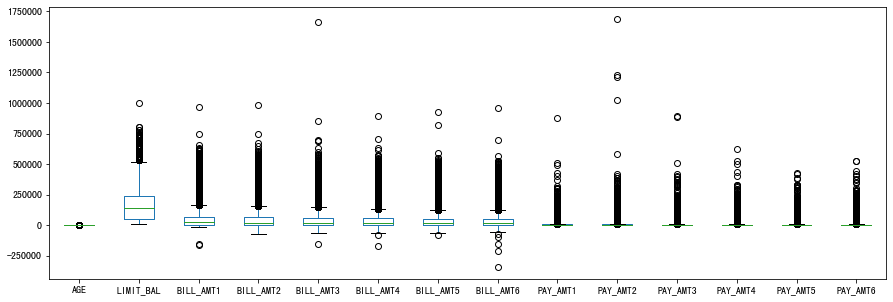

In [7]:
# 箱形图
data[numeric_col].plot(kind='box', figsize=(15,5))
plt.show()

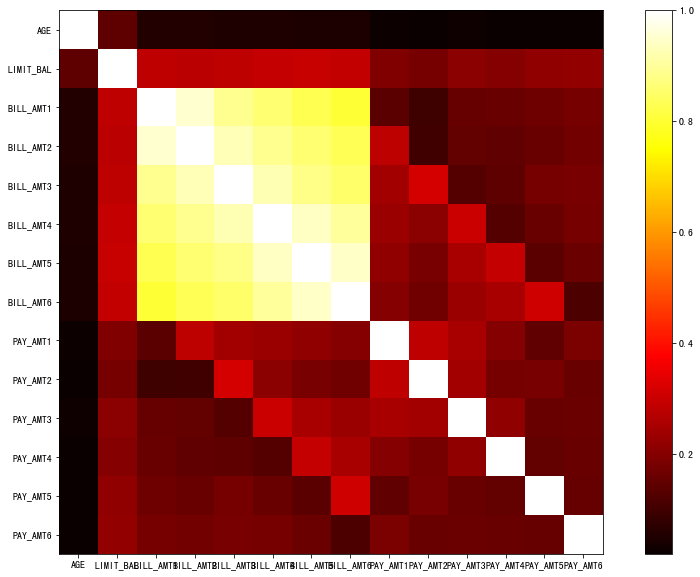

In [8]:
# 相关性查看
plt.figure(figsize=(15, 10))
plt.imshow(data[numeric_col].corr(), cmap='hot')
plt.xticks(ticks=[x for x in range(len(numeric_col))], labels=numeric_col)
plt.yticks(ticks=[x for x in range(len(numeric_col))], labels=numeric_col)
plt.colorbar()
plt.show()

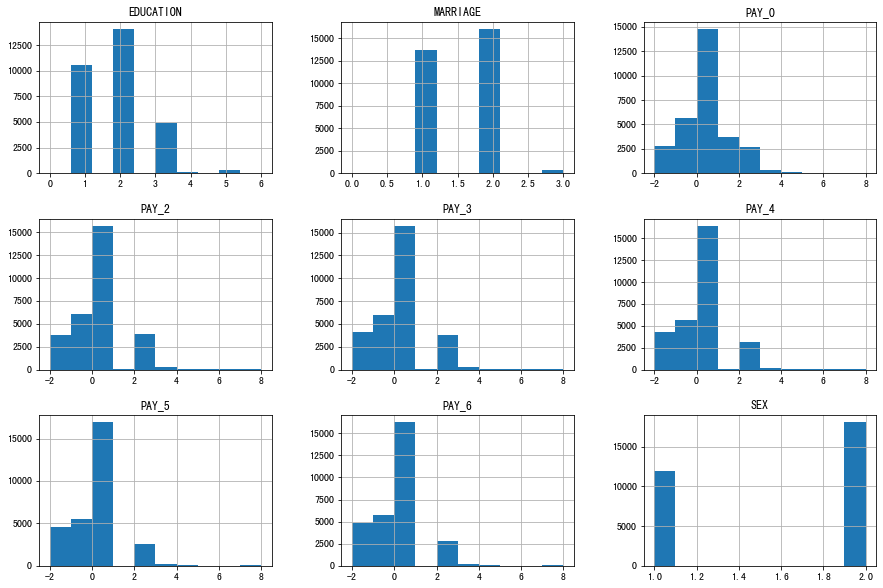

In [32]:
# 离散变量分布（部分取值没有出现在项目解释中）
data[categorical_col].hist(bins=10, figsize=(15,10))
plt.show()

# 网格搜索、管道参数

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

# 特征工程

In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectPercentile

In [12]:
# 离散变脸独热编码
data_process = data[numeric_col+categorical_col]
for col in categorical_col:
    df_temp = pd.get_dummies(data_process[col], prefix=col, prefix_sep='_')
    data_process = pd.concat([data_process, df_temp], axis=1)
data_process.drop(categorical_col, axis=1, inplace=True)

# 数据规范化

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

In [14]:
# 多种数据规范化方式
class StandarMethod(BaseEstimator, TransformerMixin):
    def __init__(self, method='StandardScaler'):
        self.method = method
        self.method_dict = {
            'StandardScaler': StandardScaler,
            'MinMaxScaler': MinMaxScaler,
            'Normalizer': Normalizer
        }

    def fit(self, X, y=None): 
        self.standar = self.method_dict[self.method]()
        self.standar.fit(X)
        return self

    def transform(self, X, y=None): 
        return self.standar.transform(X)

# 样本拆分

In [15]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [16]:
# 数据获取
x = data_process.values
y = data[label_col].values

# 数据拆分
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=526)

# 样本平衡
over_samples = SMOTE(k_neighbors=5)
x_train, y_train = over_samples.fit_sample(x_train, y_train.ravel())

# 输出样本情况
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(31262, 91)
(31262,)
(9900, 91)
(9900, 1)


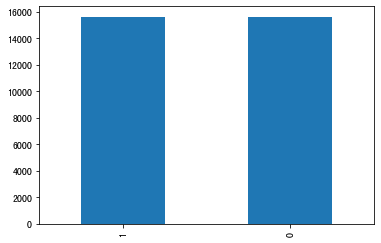

In [17]:
# 均衡样本后情况
pd.DataFrame(y_train, columns=['label'])['label'].value_counts().plot(kind='bar')
plt.show()

# 模型以及参数

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [19]:
# 分类器以及参数
models = {
    'lr': {
        'model': LogisticRegression(),
        'parameters': {'clf__penalty': ['l1', 'l2'], 'clf__C': [1.0, 2.0, 3.0]}
    },
    
    'knn': {
        'model': KNeighborsClassifier(),
        'parameters': {'clf__n_neighbors': [5, 6], 'clf__p': [1, 2]}
    },
    
    'svm': {
        'model': SVC(),
        'parameters': {'clf__kernel': ['poly', 'sigmoid', 'rbf']}
    },
    
    'rf': {
        'model': RandomForestClassifier(),
        'parameters': {'clf__n_estimators': [100, 200], 'clf__criterion': ['gini', 'entropy']}
    },
}

# 网格搜索

In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
for i in models:
    
    # 提取分类器
    classifier = models[i]['model']

    # 管道流程
    pipeline = Pipeline([
        ('select_f', SelectPercentile()),
        ('standar', StandarMethod()),
        ('clf', classifier)
    ])
    
    # 网格搜索参数增加当前分类器
    grid_parameters = ({
        'select_f__percentile': [90, 95, 100],
        'standar__method': ['Normalizer', 'StandardScaler', 'MinMaxScaler'],
    })
    
    # 添加分类器参数
    grid_parameters.update(models[i]['parameters'])

    # 搜索训练
    grid = GridSearchCV(estimator=pipeline, param_grid=grid_parameters, cv=3, scoring='f1')
    grid.fit(x_train, y_train)
    
    # 保存最好的模型
    models[i]['best'] = grid
    
    # 输出过程
    print('--- {} 分类器 ---'.format(i))
    print('best score: {:.2f}'.format(grid.best_score_))
    print('best parameters: {}'.format(grid.best_params_))
    print('---------------')


--- lr 分类器 ---
best score: 0.70
best parameters: {'clf__C': 1.0, 'clf__penalty': 'l2', 'select_f__percentile': 95, 'standar__method': 'StandardScaler'}
---------------
--- knn 分类器 ---
best score: 0.79
best parameters: {'clf__n_neighbors': 5, 'clf__p': 2, 'select_f__percentile': 100, 'standar__method': 'StandardScaler'}
---------------
--- svm 分类器 ---
best score: 0.77
best parameters: {'clf__kernel': 'poly', 'select_f__percentile': 100, 'standar__method': 'MinMaxScaler'}
---------------
--- rf 分类器 ---
best score: 0.86
best parameters: {'clf__criterion': 'gini', 'clf__n_estimators': 200, 'select_f__percentile': 100, 'standar__method': 'Normalizer'}
---------------


# 效果评估
最好的模型

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import learning_curve

In [26]:
grid = models['rf']['best']
predict = grid.predict(x_test)

In [27]:
# 指标查看
print('acc:{:.2f}%'.format(accuracy_score(y_test, predict)*100))
print('pre:{:.2f}%'.format(precision_score(y_test, predict)*100))
print('rec:{:.2f}%'.format(recall_score(y_test, predict)*100))
print('f1:{:.2f}%'.format(f1_score(y_test, predict)*100))

acc:80.91%
pre:57.87%
rec:46.98%
f1:51.86%


In [29]:
# 学习曲线
train_sizes_abs, train_scores, test_scores = learning_curve(
    estimator=grid, # 分类器
    X=x_train, # 特征
    y=y_train, # 标签
    train_sizes=np.array([0.1, 0.33, 0.55, 0.78, 1. ]),
    cv=3, # 交叉验证次数
    scoring='f1', # 评分标准，可自定义评分函数
)

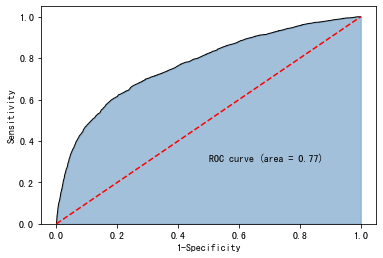

In [30]:
# ROC曲线
y_score = grid.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)
roc_auc = auc(fpr, tpr)

# 绘制面积图
plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
# 添加边际线
plt.plot(fpr, tpr, color='black', lw = 1)
# 添加对角线
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
# 添加文本信息
plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
# 添加x轴与y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
# 显示图形.predict_proba(test_features)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)

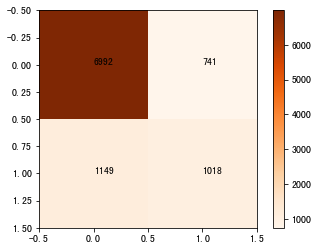

In [31]:
# 混淆矩阵
cf_matrix = confusion_matrix(y_test, predict)
plt.imshow(cf_matrix, cmap='Oranges')
plt.text(0,0, cf_matrix[0,0])
plt.text(0,1, cf_matrix[1,0])
plt.text(1,0, cf_matrix[0,1])
plt.text(1,1, cf_matrix[1,1])
plt.colorbar()
plt.show()